<a href="https://colab.research.google.com/github/crowell97/ES2245/blob/main/es2245_lecture9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EARTHSC 2245: Lecture 9 - Normality Testing

This notebook goes beyond simple p-values. We will use **visualizations** to understand *why* a specific test rejects or accepts the normality of a dataset.

**We will cover:**
1.  **Visual Inspection:** Histograms & Q-Q Plots.
2.  **Shapiro-Wilk:** The "Gold Standard" for small data.
3.  **D'Agostino's $K^2$:** Visualizing Skewness and Kurtosis.
4.  **Lilliefors / K-S Test:** Visualizing the "Max Distance" ($D$) between distributions.
5.  **Cramér-von Mises:** Checking the goodness of fit.

---
### 1. Generate Synthetic Data
We will create two distinct datasets to compare throughout this notebook:
* **`normal_data`**: A perfect bell curve.
* **`skewed_data`**: A right-skewed Log-Normal distribution (resembling things like income distribution or reaction times).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from statsmodels.stats.diagnostic import lilliefors

# Set style for nicer plots
sns.set_style("whitegrid")
np.random.seed(42)

# 1. Generate Normal Data (Mean=0, SD=1)
normal_data = np.random.normal(loc=0, scale=1, size=200)

# 2. Generate Skewed Data (Log-Normal)
skewed_data = np.random.lognormal(mean=0, sigma=0.6, size=200)

# Normalize the skewed data (center it) so it fits on similar axes
skewed_data = (skewed_data - np.mean(skewed_data)) / np.std(skewed_data)

print("Datasets generated successfully.")

Datasets generated successfully.


## 2. Visual Inspection (The "Eye Test")

Before running math, we look at the **Histogram** (for shape) and the **Q-Q Plot** (for quantiles).
* **Left:** The Histogram should look like a bell.
* **Right:** The Q-Q plot dots should hug the red line.

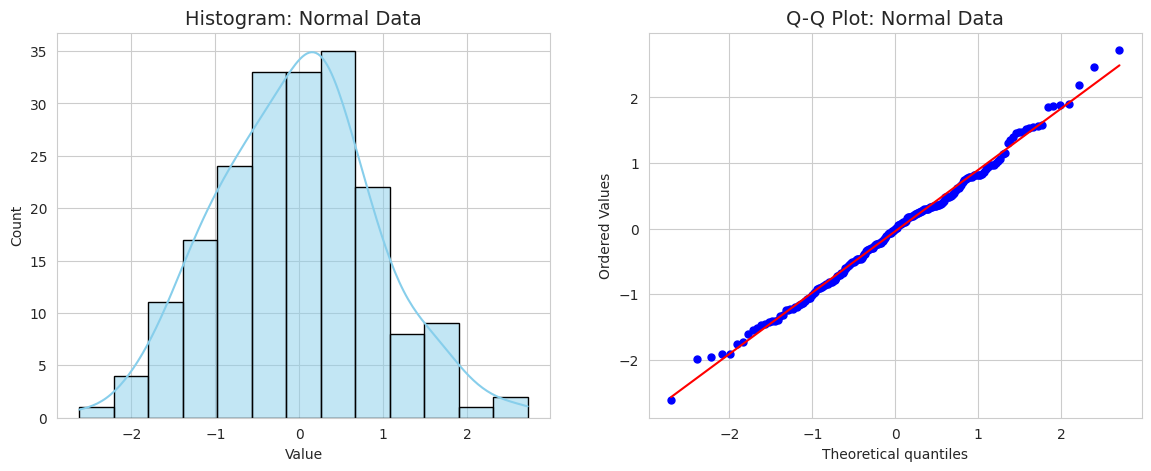

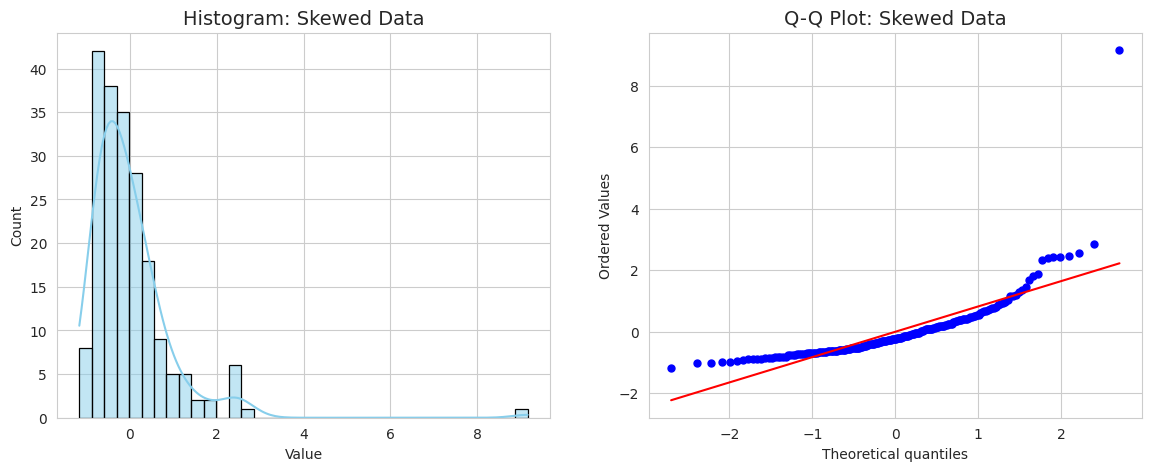

In [2]:
def plot_visual_inspection(data, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Histogram with KDE
    sns.histplot(data, kde=True, ax=ax[0], color='skyblue', edgecolor='black')
    ax[0].set_title(f'Histogram: {title}', fontsize=14)
    ax[0].set_xlabel('Value')

    # Plot 2: Q-Q Plot
    stats.probplot(data, dist="norm", plot=ax[1])
    ax[1].get_lines()[0].set_markerfacecolor('blue')
    ax[1].get_lines()[0].set_markersize(5.0)
    ax[1].set_title(f'Q-Q Plot: {title}', fontsize=14)

    plt.show()

# Run visuals
plot_visual_inspection(normal_data, "Normal Data")
plot_visual_inspection(skewed_data, "Skewed Data")

## 3. Shapiro-Wilk Test
**Focus:** Correlation between observed and expected order statistics.

This is a numerical test, so we simply output the stats. However, the logic here is tightly coupled with the Q-Q plot above. If the dots in the Q-Q plot form a straight line, the $W$ statistic will be close to 1.0.

In [3]:
def run_shapiro(data, name):
    stat, p = stats.shapiro(data)
    result = "Normal" if p > 0.05 else "NOT Normal"
    print(f"--- {name} ---")
    print(f"Statistic: {stat:.4f}, p-value: {p:.5f} -> {result}\n")

run_shapiro(normal_data, "Normal Data")
run_shapiro(skewed_data, "Skewed Data")

--- Normal Data ---
Statistic: 0.9956, p-value: 0.82899 -> Normal

--- Skewed Data ---
Statistic: 0.6770, p-value: 0.00000 -> NOT Normal



## 4. D'Agostino's $K^2$ Test (Skewness & Kurtosis)
**Focus:** Shape.
This test looks specifically for **asymmetry** (skew) and **tail thickness** (kurtosis).

The plot below visualizes the distribution and annotates these two specific values to show *why* the test might fail.

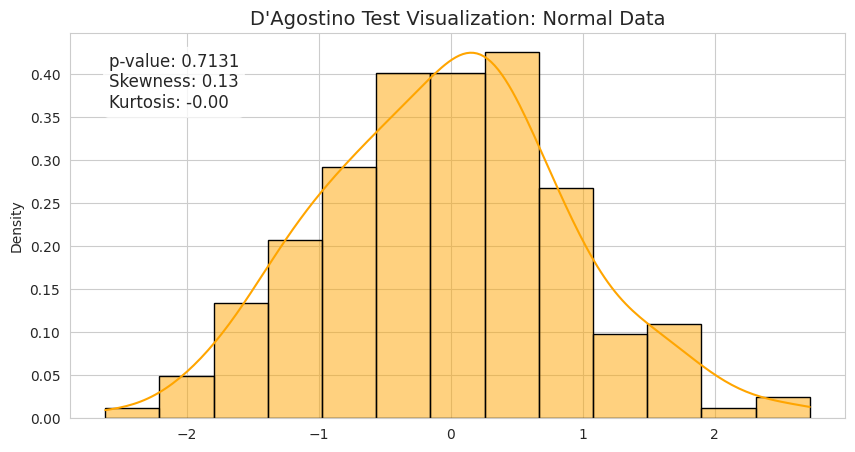

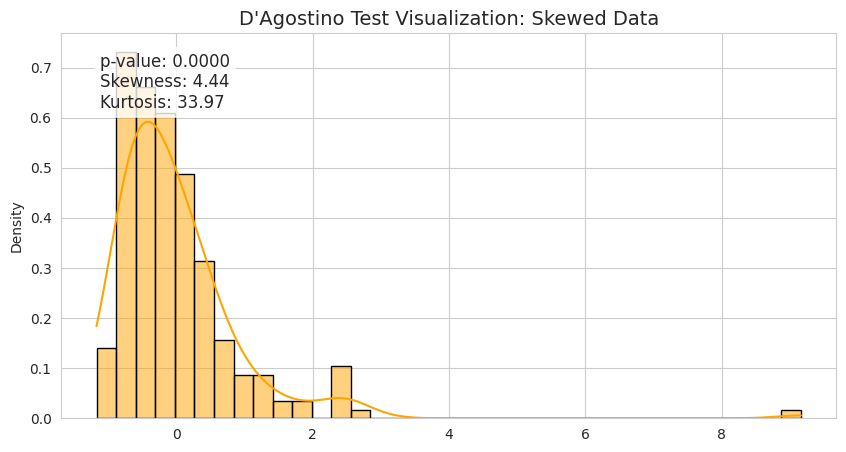

In [4]:
def plot_dagostino(data, title):
    # Calculate metrics
    k2, p = stats.normaltest(data)
    skew = stats.skew(data)
    kurt = stats.kurtosis(data) # Excess kurtosis (Normal = 0)

    # Plot
    plt.figure(figsize=(10, 5))
    sns.histplot(data, kde=True, color='orange', edgecolor='black', stat='density')

    # Add Text Box with Stats
    stats_text = (f"p-value: {p:.4f}\n"
                  f"Skewness: {skew:.2f}\n"
                  f"Kurtosis: {kurt:.2f}")

    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.gca().text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=12,
                   verticalalignment='top', bbox=props)

    plt.title(f"D'Agostino Test Visualization: {title}", fontsize=14)
    plt.show()

plot_dagostino(normal_data, "Normal Data")
plot_dagostino(skewed_data, "Skewed Data")

## 5. Lilliefors Test (Visualizing the K-S Distance)
**Focus:** The Maximum Vertical Distance ($D$).

The Lilliefors test (and K-S test) compares the **Empirical CDF** (your data) vs. the **Theoretical CDF** (perfect normal).
* The test statistic $D$ is simply the **largest gap** between these two lines.
* In the plot below, the **Red Line** represents this gap. If the gap is too big, the test rejects normality.

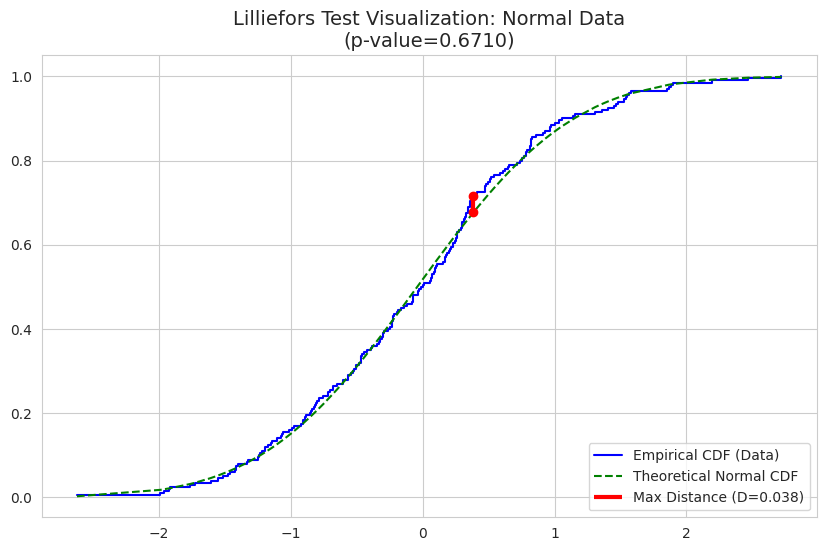

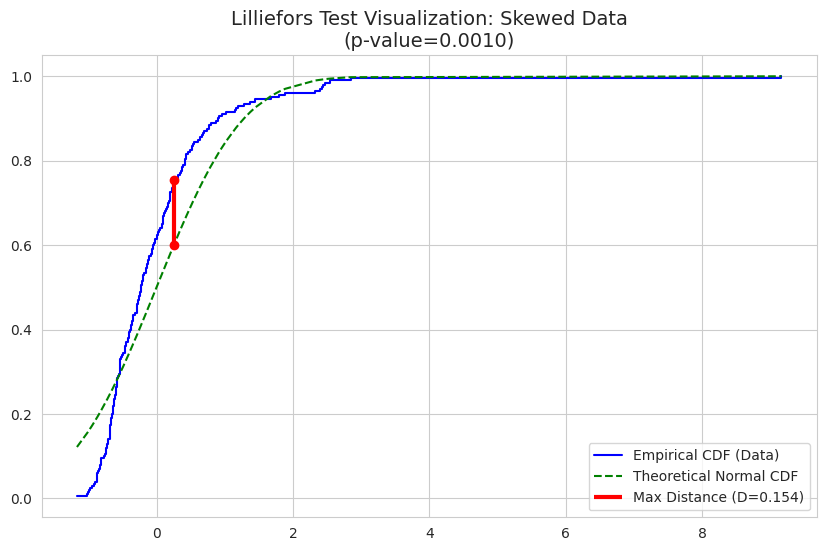

In [5]:
def plot_ks_lilliefors(data, title):
    # Sort data for ECDF
    data_sorted = np.sort(data)
    n = len(data)
    y_vals = np.arange(1, n+1) / n # ECDF y-values (0 to 1)

    # Theoretical Normal CDF (using sample mean/std)
    mean, std = np.mean(data), np.std(data)
    theoretical_cdf = stats.norm.cdf(data_sorted, mean, std)

    # Calculate D statistic (Max Distance)
    # Distance can be above or below the step, so we check both
    diffs = np.abs(theoretical_cdf - y_vals)
    max_d_idx = np.argmax(diffs)
    max_d = diffs[max_d_idx]

    # Run formal test
    stat, p = lilliefors(data)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.step(data_sorted, y_vals, label='Empirical CDF (Data)', where='post', color='blue')
    plt.plot(data_sorted, theoretical_cdf, label='Theoretical Normal CDF', color='green', linestyle='--')

    # Draw the Red Line representing the D statistic
    x_point = data_sorted[max_d_idx]
    y_emp = y_vals[max_d_idx]
    y_theo = theoretical_cdf[max_d_idx]

    plt.vlines(x_point, y_emp, y_theo, color='red', linewidth=3, label=f'Max Distance (D={max_d:.3f})')
    plt.scatter([x_point], [y_emp], color='red', zorder=5)
    plt.scatter([x_point], [y_theo], color='red', zorder=5)

    plt.title(f"Lilliefors Test Visualization: {title}\n(p-value={p:.4f})", fontsize=14)
    plt.legend(loc='lower right')
    plt.show()

plot_ks_lilliefors(normal_data, "Normal Data")
plot_ks_lilliefors(skewed_data, "Skewed Data")

## 6. Cramér-von Mises Test
**Focus:** The Total Squared Error.

While the plot above (Lilliefors) looked for the *single* biggest red line, Cramér-von Mises effectively looks at the "area" between the Blue and Green curves across the entire plot.

This makes it less sensitive to a single outlier and more sensitive to the overall fit.

In [6]:
# Standardize data for CVM (required for simple use of 'norm' distribution in scipy)
def run_cvm(data, name):
    std_data = (data - np.mean(data)) / np.std(data)
    res = stats.cramervonmises(std_data, 'norm')

    result = "Normal" if res.pvalue > 0.05 else "NOT Normal"
    print(f"--- {name} ---")
    print(f"Statistic: {res.statistic:.4f}, p-value: {res.pvalue:.5f} -> {result}\n")

run_cvm(normal_data, "Normal Data")
run_cvm(skewed_data, "Skewed Data")

--- Normal Data ---
Statistic: 0.0416, p-value: 0.92497 -> Normal

--- Skewed Data ---
Statistic: 1.8976, p-value: 0.00002 -> NOT Normal

